In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from utils.train_utils import *
warnings.filterwarnings(action='ignore')
path = '../data/train_results/evening_results/'

In [15]:
## cycle result
with open(path + 'e_cycle_results_list.pkl', 'rb') as f:
    cycle_results_list = pickle.load(f)

train_x_cycle, train_y_cycle, train_pred_cycle,\
valid_time_x_cycle, valid_x_cycle, valid_y_cycle = cycle_results_list

In [16]:
## trend
with open(path + 'e_trend_results_list.pkl', 'rb') as f:
    trend_results_list = pickle.load(f)

train_x_trend, train_y_trend, train_pred_trend,\
valid_time_x_trend, valid_x_trend, valid_y_trend = trend_results_list

In [17]:
###  scaler
with open('../data/preprocess/scalers.pkl', 'rb') as f:
    sclaers = pickle.load(f)# [m_time_scaler, l_time_scaler, e_time_scaler, no_time_scaler]
time_scaler = sclaers[2]

In [18]:
new_trend_results_list = []
for data in trend_results_list:
    shape = data.shape
    data = time_scaler.inverse_transform(data.reshape(-1), select_col = 0)
    new_trend_results_list.append(data.reshape(shape))

new_cycle_results_list = []
for data in cycle_results_list:
    shape = data.shape
    data = time_scaler.inverse_transform(data.reshape(-1), select_col = 1)
    new_cycle_results_list.append(data.reshape(shape))

total_results_list = []
for i in range(6):
    total_results_list.append(new_trend_results_list[i] + new_cycle_results_list[i])

In [19]:
train_x, train_y, train_pred,\
valid_time_x, valid_x, valid_y = total_results_list

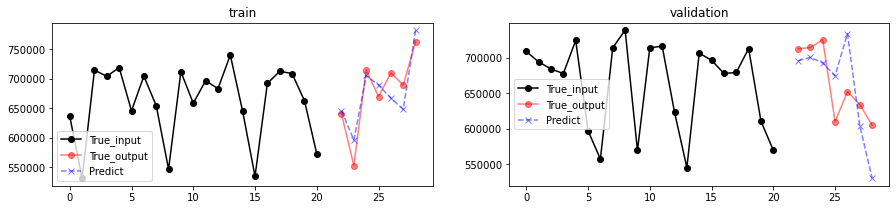

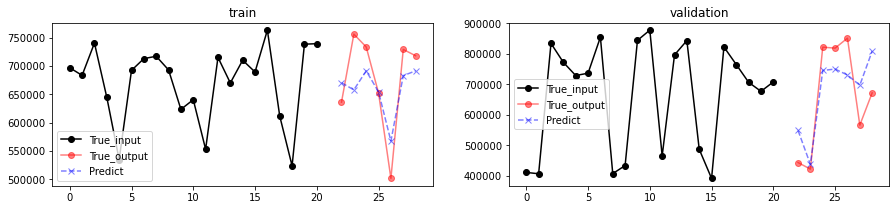

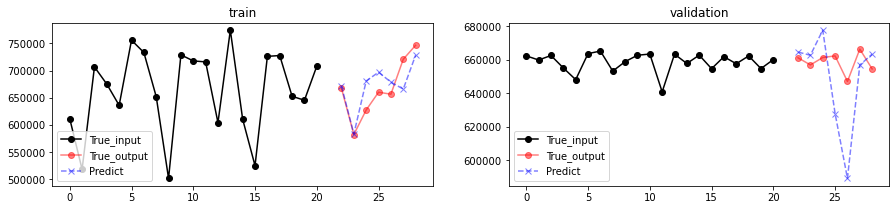

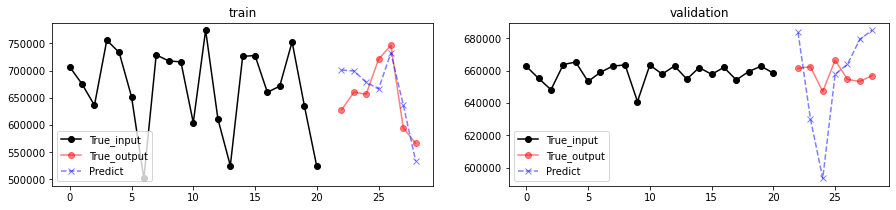

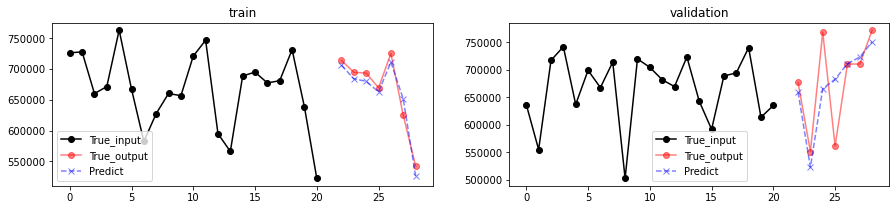

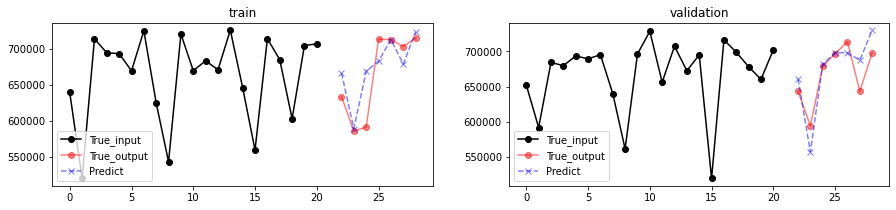

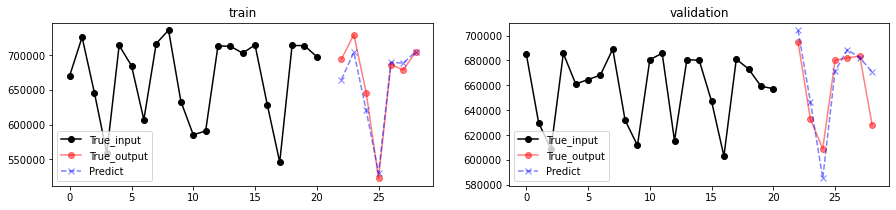

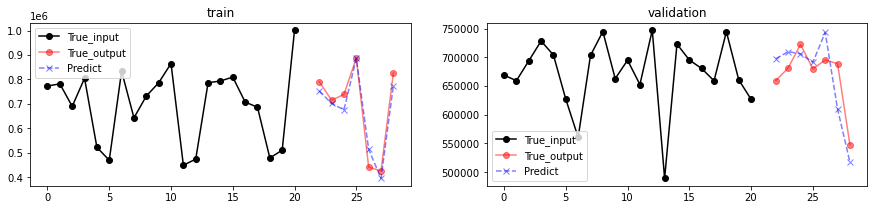

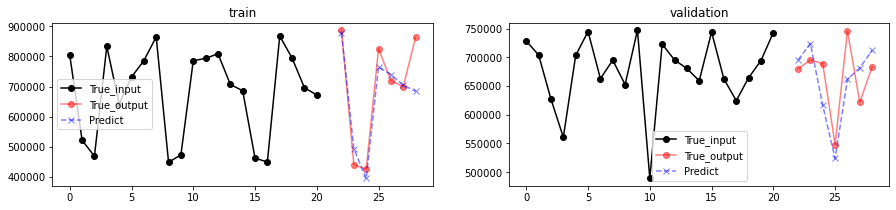

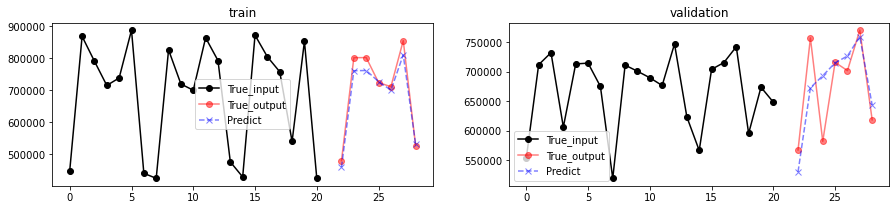

In [20]:
plot_predict(train_x, train_y, train_pred,\
                valid_time_x, valid_x, valid_y )

with open(path + 'e_total_results_list.pkl', 'wb') as f:
    pickle.dump(total_results_list, f)            

In [21]:
### evening scaler
with open('../data/preprocess/scalers.pkl', 'rb') as f:
    sclaers = pickle.load(f)# [m_time_scaler, l_time_scaler, e_time_scaler, no_time_scaler]
time_scaler = sclaers[2]

with open('../data/preprocess/june_data/evening_june_time.pkl', 'rb') as f:
    evening_time = pickle.load(f)
with open('../data/predict_june/predict_cycle_trend/june_evening_cycle_pred.pkl', 'rb') as f:
    evening_cycle_pred = pickle.load(f)
with open('../data/predict_june/predict_cycle_trend/june_evening_trend_pred.pkl', 'rb') as f:
    evening_trend_pred = pickle.load(f)

In [22]:
def resize(data, select_col = 0):
    shape = data.shape
    data = time_scaler.inverse_transform(data.reshape(-1), select_col = 0)
    return data.reshape(shape)

In [23]:
evening_pred = evening_trend_pred + evening_cycle_pred
evening_x = evening_time[:,:,-2] + evening_time[:,:,-1]
evening_pred = resize(evening_pred, select_col = 0)
evening_x = resize(evening_x, select_col = 0)

In [24]:
nontime = pd.read_csv('../data/original/nontime_data.txt', sep = ' ')
time = pd.read_csv('../data/original/time_data.txt', sep = ' ')

In [25]:
dong_list= time.HDONG_NM.unique()

code_list = [1114065000, 1114061500, 2726066200, 2726061000, 2711067000,
       2726065100, 1114066500, 2726062000, 2726051000, 1135057000,
       2711068000, 1114068000, 2726068000, 1135063000, 1114067000,
       2711069000, 1114055000, 2726053000, 1135070000, 1114059000,
       1135062400, 1135059500, 1135061200, 1114054000, 2711064000,
       1135061100, 1114062500, 2711066000, 1114064500, 2726055000,
       1135069500, 1135072000, 2726056000, 2711054500, 2726064000,
       1135060000, 2726060100, 1135062500, 2726052000, 2726063000,
       2726069000, 2726065200, 2726059000, 2711051700, 2726057000,
       1114052000, 2726066100, 1135067000, 1114060500, 1135066500,
       2726054000, 2711065000, 1135056000, 2726060200, 2726067000,
       1135058000, 2711058500, 1114063500, 1135064000, 2726056100,
       1135062100, 2726058000, 2711056500, 1135061900, 1135071000,
       1114058000, 1114057000, 2711057500, 2711059500]
def name2index(dong_name):
    for idx, code in enumerate(code_list):
        if code == time[time.HDONG_NM == dong_name].HDONG_CD.iloc[0]:
            return(idx)
        
pred_june = pd.DataFrame([evening_pred[name2index(dong)] for dong in dong_list])
pred_june.columns = ['2020-06-01','2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07']
pred_june.index = dong_list
pred_june['AREA'] = [nontime[nontime.HDONG_NM == dong].AREA.iloc[0] for dong in dong_list]
how_insame = pred_june.copy()
how_inother = pred_june.copy()

def find_level(pred, dong_name):
    '''
    0 ~20 : 1 
    20~40 : 2
    40~60 : 3
    60~80 : 4
    80~100: 5
    '''
    dist = np.array(time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].sort_values())
    for idx, val in enumerate(dist):
        if val > pred:
            break
    if idx == 30-1:
        return 1
    else:
        return int(((idx+1)/30) * 100 // 20) + 1
for dong in dong_list:
    for day in ['2020-06-01','2020-06-02','2020-06-03','2020-06-04','2020-06-05','2020-06-06','2020-06-07']:
        how_insame.loc[dong,day] = find_level(pred_june.loc[dong,day],dong)

flowperarea = pd.DataFrame({'flowperarea':pred_june.iloc[:,:7].mean(axis = 1)})
for idx, dong in enumerate(dong_list):
    flowperarea.iloc[idx] = flowperarea.iloc[idx] / nontime[nontime.HDONG_NM == dong].AREA.iloc[0] * 100
flowperarea = np.array(flowperarea.flowperarea.sort_values())

def find_level_other(pred, dong_name):
    '''
    0 ~20 : 1 
    20~40 : 2
    40~60 : 3
    60~80 : 4
    80~100: 5
    '''
    for idx, val in enumerate(flowperarea):
        if val > pred:
            break
    if idx == 68:
        return 1
    else:
        return int(((idx+1)/69) * 100 // 20) + 1
        
how_inother = pred_june.copy()
for dong in dong_list:
    for day in ['2020-06-01','2020-06-02','2020-06-03','2020-06-04','2020-06-05','2020-06-06','2020-06-07']:
        how_inother.loc[dong,day] = find_level_other(how_inother.loc[dong,day] / how_inother.loc[dong,"AREA"] * 100, dong)
how_inother.loc[['중림동','소공동','회현동']]

,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,AREA
중림동,3.0,4.0,4.0,4.0,4.0,3.0,3.0,482329.92
소공동,5.0,5.0,5.0,5.0,5.0,5.0,4.0,893419.62
회현동,1.0,1.0,1.0,1.0,1.0,5.0,5.0,847351.57


In [30]:
how_insame.to_csv('../data/predict_june/result_june/evening_insame.csv')
how_inother.to_csv('../data/predict_june/result_june/evening_inother.csv')

In [31]:
print("저녁")
display(how_insame.loc[['중림동','소공동','회현동']])
display(how_inother.loc[['중림동','소공동','회현동']])

저녁


,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,AREA
중림동,2.0,3.0,3.0,3.0,4.0,2.0,2.0,482329.92
소공동,3.0,3.0,3.0,3.0,3.0,2.0,2.0,893419.62
회현동,2.0,3.0,3.0,3.0,3.0,2.0,1.0,847351.57


,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,AREA
중림동,3.0,4.0,4.0,4.0,4.0,3.0,3.0,482329.92
소공동,5.0,5.0,5.0,5.0,5.0,5.0,4.0,893419.62
회현동,1.0,1.0,1.0,1.0,1.0,5.0,5.0,847351.57
